# CLASSIFICATION - SVM (Support Vector Machine)
## Classification des prix immobiliers (House-Data.csv)
### OMGBA Joseph

**Objectif**: Classifier les maisons en 3 catégories de prix (Bas/Moyen/Élevé)

**Justification du choix de la classification**:
> Dans la pratique immobilière, les acheteurs cherchent souvent une **gamme de prix** plutôt qu'un prix exact. Classifier en catégories permet de :
> - Simplifier la décision d'achat
> - Évaluer les performances avec des métriques claires (accuracy, ROC)
> - Utiliser le modèle SVM dans sa forme classique (SVC)

# PREPROCESSING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             RocCurveDisplay, roc_auc_score, f1_score)


In [2]:
# Charger les données
data = pd.read_csv('House-Data.csv')

print(" Aperçu des données ")
print(data.head())
print("\nDimensions :", data.shape)
print("\nTypes de données :\n", data.dtypes)

 Aperçu des données 
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zi

In [3]:
# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isna().sum())

# Remplacer par la moyenne si nécessaire
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].isnull().any():
        data[col].fillna(data[col].mean(), inplace=True)
        print(f"Valeurs manquantes dans {col} remplacées par la moyenne.")


Valeurs manquantes par colonne :
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [4]:
# Vérification et suppression des doublons
print("\nNombre de doublons :", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print(f"Dimensions après suppression : {data.shape}")


Nombre de doublons : 0
Dimensions après suppression : (21613, 21)


In [5]:
# Supprimer les colonnes non pertinentes pour la prédiction
columns_to_drop = ['id', 'date']
data = data.drop(columns=columns_to_drop, errors='ignore')
print(f"Colonnes supprimées : {columns_to_drop}")
print(f"Nouvelles dimensions : {data.shape}")

Colonnes supprimées : ['id', 'date']
Nouvelles dimensions : (21613, 19)


In [6]:
# Description statistique
print("\nDescription statistique :")
data.describe()


Description statistique :


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


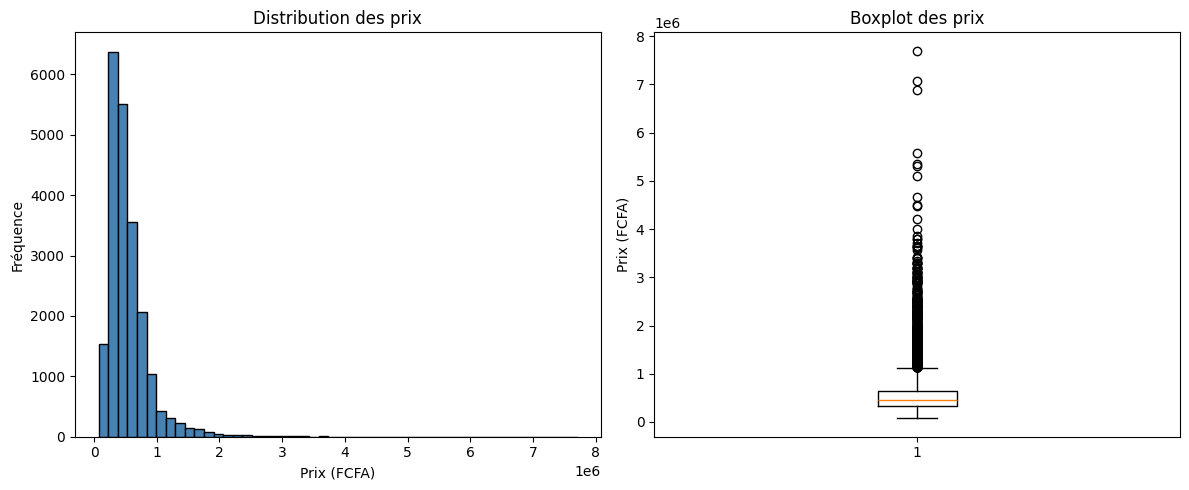

In [7]:
# Distribution des prix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['price'], bins=50, color='steelblue', edgecolor='black')
plt.title('Distribution des prix')
plt.xlabel('Prix (FCFA)')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
plt.boxplot(data['price'])
plt.title('Boxplot des prix')
plt.ylabel('Prix (FCFA)')

plt.tight_layout()
plt.show()

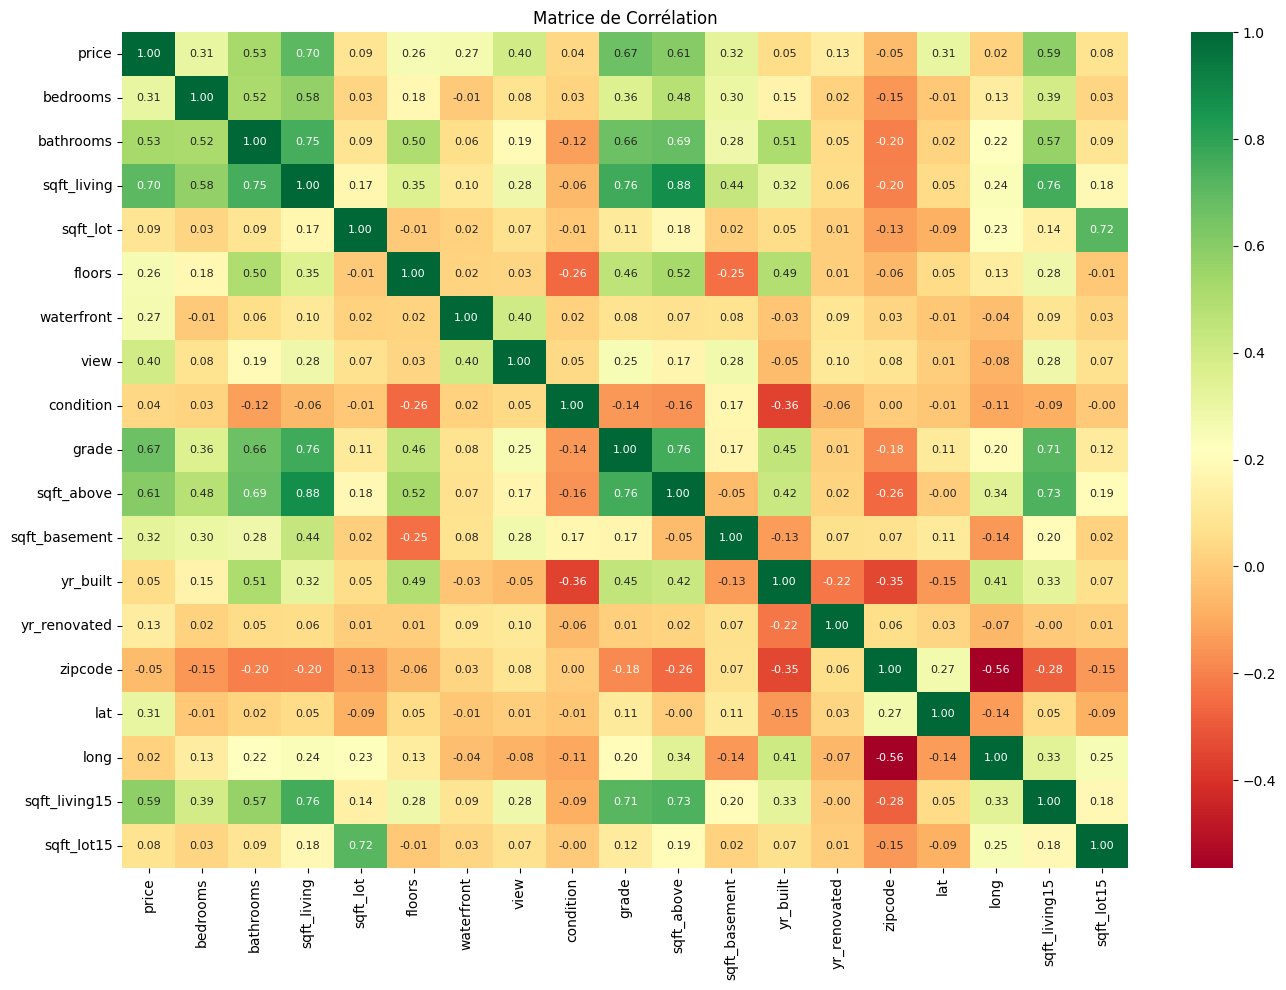

In [8]:
# Matrice de corrélation
plt.figure(figsize=(14, 10))
correlation_matrix = data.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt='.2f', annot_kws={'size': 8})
plt.title("Matrice de Corrélation")
plt.tight_layout()
plt.show()

## Création de la variable cible (Catégories de prix)

In [ ]:
# Définir les catégories de prix
def categorize_price(price):
    if price < 300000:
        return 0  # Prix Bas
    elif price < 600000:
        return 1  # Prix Moyen
    else:
        return 2  # Prix Élevé

# Appliquer la catégorisation
data['price_category'] = data['price'].apply(categorize_price)

# Afficher la distribution des catégories
print("Distribution des catégories de prix :")
print(data['price_category'].value_counts().sort_index())

# Labels pour l'affichage
category_labels = {0: 'Prix Bas (<300k)', 1: 'Prix Moyen (300k-600k)', 2: 'Prix Élevé (>600k)'}
for cat, label in category_labels.items():
    count = (data['price_category'] == cat).sum()
    print(f"  {cat} - {label}: {count} ({count/len(data)*100:.1f}%)")

Distribution des catégories de prix :
price_category
0     4437
1    10810
2     6366
Name: count, dtype: int64
  0 - Prix Bas (<300k): 4437 (20.5%)
  1 - Prix Moyen (300k-600k): 10810 (50.0%)
  2 - Prix Élevé (>600k): 6366 (29.5%)


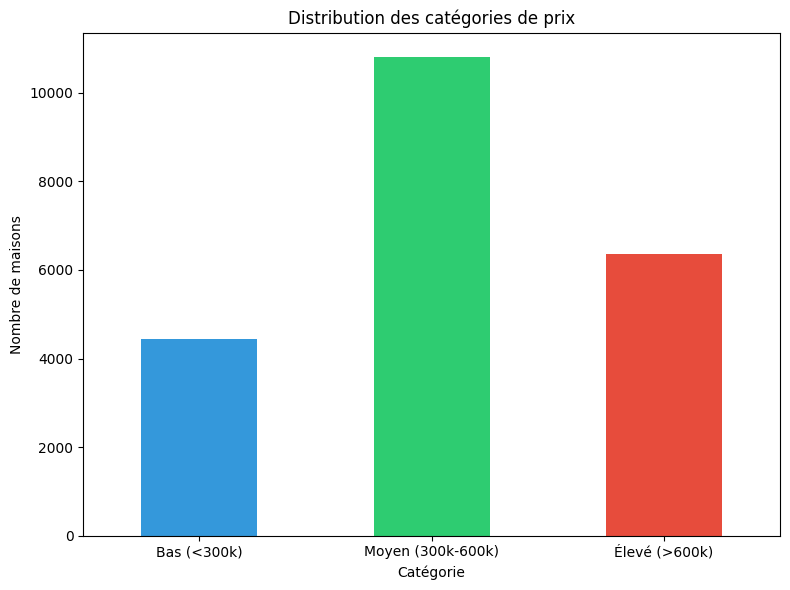

In [10]:
# Visualiser la distribution des catégories
plt.figure(figsize=(8, 6))
colors = ['#3498db', '#2ecc71', '#e74c3c']
data['price_category'].value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Distribution des catégories de prix')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de maisons')
plt.xticks([0, 1, 2], ['Bas (<300k)', 'Moyen (300k-600k)', 'Élevé (>600k)'], rotation=0)
plt.tight_layout()
plt.show()

## Séparation des données

In [11]:
# Séparer les features et la cible
X = data.drop(['price', 'price_category'], axis=1)
y = data['price_category']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nFeatures utilisées: {list(X.columns)}")

Shape de X: (21613, 18)
Shape de y: (21613,)

Features utilisées: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [12]:
# Division Train/Test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribution y_train: {y_train.value_counts().to_dict()}")
print(f"Distribution y_test: {y_test.value_counts().to_dict()}")

X_train: (15129, 18)
X_test: (6484, 18)

Distribution y_train: {1: 7604, 2: 4409, 0: 3116}
Distribution y_test: {1: 3206, 2: 1957, 0: 1321}


In [13]:
# Standardisation (critique pour SVM)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

print("Standardisation effectuée.")

Standardisation effectuée.


# MODELE SVM CLASSIQUE

In [14]:
# Création et entraînement du modèle SVM classique
classifier = SVC(kernel='linear', random_state=0, probability=True)
classifier.fit(X_train_sc, y_train)

print("Modèle SVM entraîné avec succès.")

Modèle SVM entraîné avec succès.


### Critères d'évaluation du modèle classique

In [15]:
# Prédictions
y_pred_train = classifier.predict(X_train_sc)
y_pred_test = classifier.predict(X_test_sc)

print("--- Performance du Modèle Classique ---")
print(f"Accuracy sur train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy sur test: {accuracy_score(y_test, y_pred_test):.4f}")

--- Performance du Modèle Classique ---
Accuracy sur train: 0.7869
Accuracy sur test: 0.7767


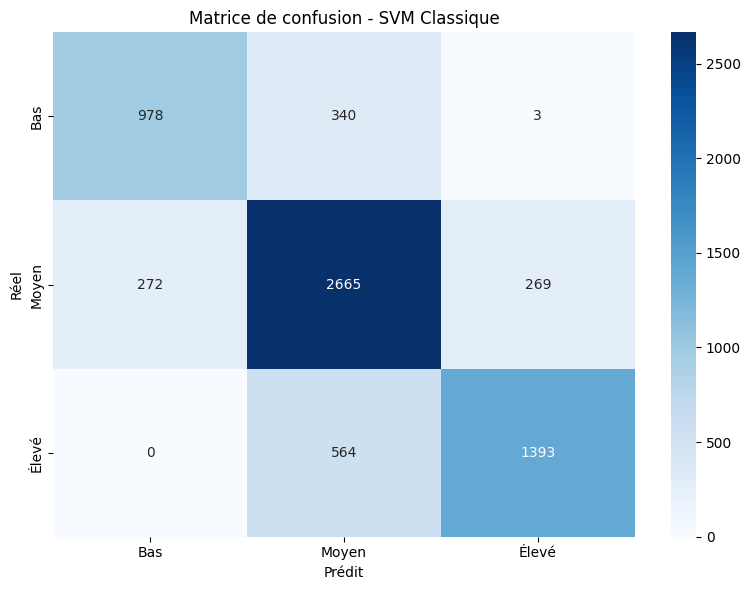

In [16]:
# 1 - Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bas', 'Moyen', 'Élevé'],
            yticklabels=['Bas', 'Moyen', 'Élevé'])
plt.title('Matrice de confusion - SVM Classique')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

In [17]:
# 2 - Classification report
print("Classification Report - SVM Classique:")
print(classification_report(y_test, y_pred_test, target_names=['Prix Bas', 'Prix Moyen', 'Prix Élevé']))

Classification Report - SVM Classique:
              precision    recall  f1-score   support

    Prix Bas       0.78      0.74      0.76      1321
  Prix Moyen       0.75      0.83      0.79      3206
  Prix Élevé       0.84      0.71      0.77      1957

    accuracy                           0.78      6484
   macro avg       0.79      0.76      0.77      6484
weighted avg       0.78      0.78      0.78      6484



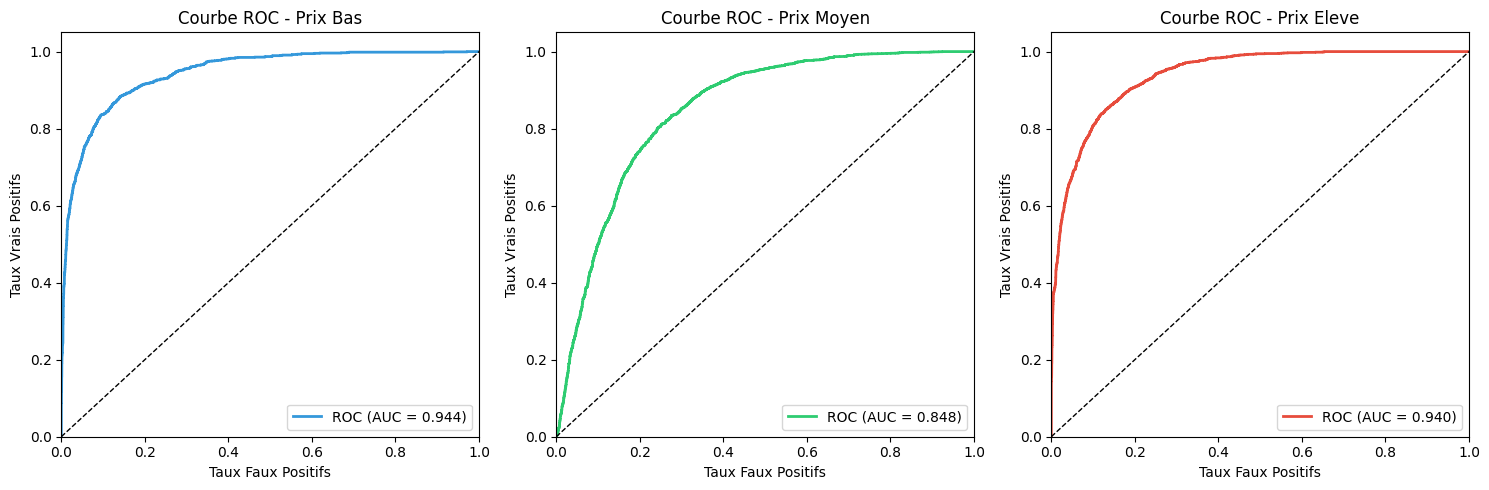

In [21]:
# 3 - Courbe ROC (One vs Rest pour multiclasse)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binariser les labels pour ROC multiclasse
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = classifier.predict_proba(X_test_sc)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = ['Prix Bas', 'Prix Moyen', 'Prix Eleve']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, (ax, class_name, color) in enumerate(zip(axes, class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux Faux Positifs')
    ax.set_ylabel('Taux Vrais Positifs')
    ax.set_title(f'Courbe ROC - {class_name}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [22]:
# 4 - Calcul de l'AUC-ROC global (One vs Rest)
y_pred_proba = classifier.predict_proba(X_test_sc)
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"AUC-ROC : {auc_ovr:.4f}")

AUC-ROC : 0.8953


# OPTIMISATION DU MODELE SVM

In [23]:
# Échantillonnage pour accélérer GridSearchCV (SVM est lent sur gros datasets)
sample_size = min(5000, len(X_train_sc))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_sc), sample_size, replace=False)
X_train_sample = X_train_sc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

print(f"Taille de l'échantillon pour GridSearchCV: {sample_size}")

Taille de l'échantillon pour GridSearchCV: 5000


In [24]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

print("Paramètres à tester:", param_grid)

Paramètres à tester: {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}


In [25]:
# GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample, y_train_sample)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=1)

In [26]:
# Meilleurs paramètres
print("Meilleurs paramètres:")
print(grid_search.best_params_)
print(f"\nMeilleur score (CV): {grid_search.best_score_:.4f}")

Meilleurs paramètres:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Meilleur score (CV): 0.8220


In [27]:
# Entraîner le modèle final avec les meilleurs paramètres sur TOUTES les données
best_svm = SVC(
    **grid_search.best_params_,
    probability=True,
    random_state=42
)
best_svm.fit(X_train_sc, y_train)

print("Modèle optimisé entraîné sur l'ensemble des données d'entraînement.")

Modèle optimisé entraîné sur l'ensemble des données d'entraînement.


### Critères d'évaluation du modèle optimisé

In [28]:
# Prédictions avec le modèle optimisé
y_pred_train_opt = best_svm.predict(X_train_sc)
y_pred_test_opt = best_svm.predict(X_test_sc)

print("--- Performance du Modèle Optimisé ---")
print(f"Accuracy sur train: {accuracy_score(y_train, y_pred_train_opt):.4f}")
print(f"Accuracy sur test: {accuracy_score(y_test, y_pred_test_opt):.4f}")

--- Performance du Modèle Optimisé ---
Accuracy sur train: 0.8550
Accuracy sur test: 0.8308


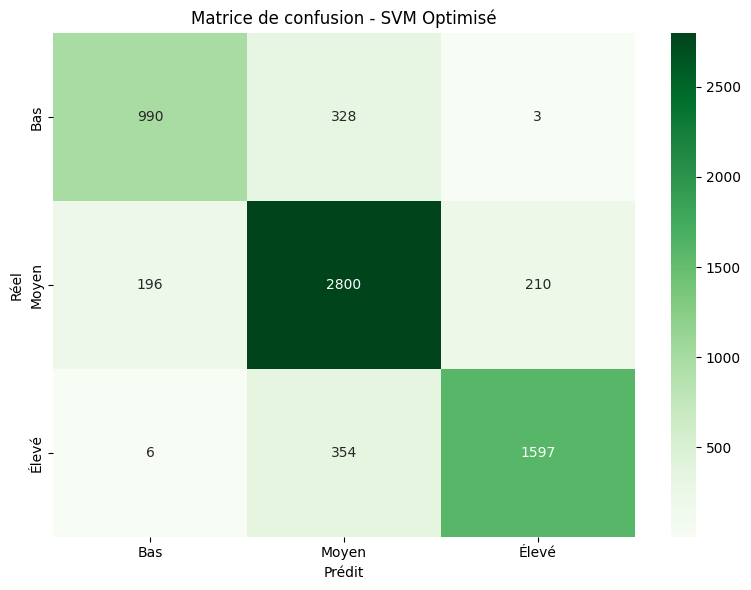

In [29]:
# 1 - Matrice de confusion - Modèle optimisé
cm_opt = confusion_matrix(y_test, y_pred_test_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bas', 'Moyen', 'Élevé'],
            yticklabels=['Bas', 'Moyen', 'Élevé'])
plt.title('Matrice de confusion - SVM Optimisé')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

In [30]:
# 2 - Classification report - Modèle optimisé
print("Classification Report - SVM Optimisé:")
print(classification_report(y_test, y_pred_test_opt, target_names=['Prix Bas', 'Prix Moyen', 'Prix Élevé']))

Classification Report - SVM Optimisé:
              precision    recall  f1-score   support

    Prix Bas       0.83      0.75      0.79      1321
  Prix Moyen       0.80      0.87      0.84      3206
  Prix Élevé       0.88      0.82      0.85      1957

    accuracy                           0.83      6484
   macro avg       0.84      0.81      0.82      6484
weighted avg       0.83      0.83      0.83      6484



In [ ]:
# 3 - Courbe ROC - Modele optimise
# Binariser les labels pour ROC multiclasse
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba_opt = best_svm.predict_proba(X_test_sc)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = ['Prix Bas', 'Prix Moyen', 'Prix Eleve']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, (ax, class_name, color) in enumerate(zip(axes, class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_opt[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux Faux Positifs')
    ax.set_ylabel('Taux Vrais Positifs')
    ax.set_title(f'Courbe ROC Optimisee - {class_name}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# 4 - Calcul de l'AUC-ROC global - Modèle optimisé
y_pred_proba_opt = best_svm.predict_proba(X_test_sc)
auc_ovr_opt = roc_auc_score(y_test, y_pred_proba_opt, multi_class='ovr', average='weighted')
print(f"AUC-ROC Optimisé (One vs Rest, weighted): {auc_ovr_opt:.4f}")

## Comparaison des modèles

In [ ]:
# Comparaison des performances
print("=" * 60)
print("COMPARAISON DES MODELES SVM")
print("=" * 60)
print(f"\nModèle Classique (kernel=linear):")
print(f"  - Accuracy train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"  - Accuracy test: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"  - AUC-ROC: {auc_ovr:.4f}")
print(f"\nModèle Optimisé ({grid_search.best_params_}):")
print(f"  - Accuracy train: {accuracy_score(y_train, y_pred_train_opt):.4f}")
print(f"  - Accuracy test: {accuracy_score(y_test, y_pred_test_opt):.4f}")
print(f"  - AUC-ROC: {auc_ovr_opt:.4f}")
print(f"\nMeilleurs paramètres: {grid_search.best_params_}")

# PREDICTION AVEC LE MODELE OPTIMISE

In [ ]:
# Exemple de prédiction
sample = X_test.iloc[0:5]
sample_sc = sc.transform(sample)

predictions = best_svm.predict(sample_sc)
predictions_proba = best_svm.predict_proba(sample_sc)

category_names = ['Prix Bas (<300k)', 'Prix Moyen (300k-600k)', 'Prix Élevé (>600k)']

print("Prédictions pour 5 échantillons:")
for i, (pred, proba) in enumerate(zip(predictions, predictions_proba)):
    real = y_test.iloc[i]
    print(f"  {i+1}. Prédit: {category_names[pred]} | Réel: {category_names[real]} | Confiance: {max(proba)*100:.1f}%")

# SAUVEGARDE DU MODELE

In [ ]:
import pickle

# Sauvegarder le modèle, le scaler et les features
model_data = {
    'model': best_svm,
    'scaler': sc,
    'features': list(X.columns),
    'category_names': category_names,
    'best_params': grid_search.best_params_
}

with open('houseSVM.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Modèle sauvegardé dans 'houseSVM.pkl'")
print(f"Features: {list(X.columns)}")

# RÉSUMÉ FINAL

In [ ]:
print("=" * 70)
print("                         RÉSUMÉ FINAL")
print("=" * 70)
print(f"""
DATASET:
  - Fichier: House-Data.csv
  - Dimensions: {data.shape}
  - Split: 70% train / 30% test

CLASSIFICATION:
  - Catégorie 0: Prix Bas (<300kFCFA)
  - Catégorie 1: Prix Moyen (300k-600kFCFA)
  - Catégorie 2: Prix Élevé (>600kFCFA)

PREPROCESSING:
  - Suppression colonnes: id, date
  - StandardScaler appliqué

OPTIMISATION:
  - GridSearchCV avec échantillonnage ({sample_size} lignes)
  - Meilleurs paramètres: {grid_search.best_params_}

PERFORMANCES FINALES:
  - Accuracy:  {accuracy_score(y_test, y_pred_test_opt):.4f}
  - AUC-ROC:   {auc_ovr_opt:.4f}
  - F1-Score:  {f1_score(y_test, y_pred_test_opt, average='weighted'):.4f}

FICHIER SAUVEGARDÉ: houseSVM.pkl
""")
print("=" * 70)